In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import abc
import matplotlib as mpl
import numpy as np
import os
import pandas as pd
import seaborn as sns
import torch
import typing

from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from operator import itemgetter
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from torch import nn
from ttb import Dataset

from lib.model import (
    ClassifierDriftModel,
    ClassifierUncertaintyModel,
    CVMModel,
    FETModel,
    LearnedKernelModel,
    MMDModel,
    ModelWrapperInterface,
    SpotTheDiffModel,
    TabularModel,
)
from alibi_detect.utils.pytorch.kernels import DeepKernel
from lib.data_aug_utils import (
    dollars_per_mile,
    pickup_day_in_month,
    pickup_day_in_week,
    pickup_month_inc_year,
    pickup_time_sice_midnight,
    tip_percent_column,
)
from lib.data_clean_utils import hard_coded_cleaning_steps_mutation
from lib.data_load_utils import (
    AccessorFactory,
    AnnotatedTrainTestDataFrameAccessor,
    batch_load_df,
    date_iter_step_size,
    TrainTestDataFrameAccessor,
)

In [2]:
global_start_date = datetime.strptime("2020-11-15", "%Y-%m-%d")
global_end_date = datetime.strptime("2021-01-01", "%Y-%m-%d")
dataset = Dataset("taxi_data", cutoff_date=global_end_date, backend="pandas")

'''
    Loading large datasets can cause memory use to spike, so we batch loading here.
'''
df = batch_load_df(dataset, global_start_date, global_end_date, 1, 'tqdm')
hard_coded_cleaning_steps_mutation(df)
df.insert(1, 'pickup_month_inc_year', pickup_month_inc_year(df['tpep_pickup_datetime']))
df.insert(2, 'pickup_day_in_month', pickup_day_in_month(df['tpep_pickup_datetime']))
df.insert(3, 'pickup_mins_since_midnight', pickup_time_sice_midnight(df['tpep_pickup_datetime']))
df.insert(14, 'tip_percent', tip_percent_column(df['total_amount'], df['tip_amount']))
df.insert(15, 'tip_percent_greater_15', df['tip_percent'] > .15)
df.insert(21, 'total_amount_per_mile', dollars_per_mile(df['total_amount'], df['trip_distance']))

df_sample = df.sample(frac=.0005)

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\HP\anaconda3\envs\ttb\lib\site-packages\pandas\io\sql.py:758: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
100%|██████████| 1/1 [00:56<00:00, 56.79s/it]


In [3]:
'''
    Some drift detection methods benefit from the knowledge of
    what features are categorical.
'''
is_continuous_annotations = {
    'congestion_surcharge': False,
    'dolocationid': False,
    'extra': False,
    'fare_amount': True,
    'id': False,
    'improvement_surcharge': False,
    'mta_tax': False,
    'passenger_count': False,
    'payment_type': False,
    'pickup_day_in_month': True,
    'pickup_mins_since_midnight': True,
    'pickup_month_inc_year': False,
    'pulocationid': False,
    'ratecodeid': False,
    'store_and_fwd_flag': False,
    'tip_amount': True,
    'tip_percent_greater_15': False,
    'tip_percent': True,
    'tolls_amount': True,
    'total_amount_per_mile': True,
    'total_amount': True,
    'trip_distance': True,
    'vendorid': False,
}

In [4]:
x_labels = [
       'congestion_surcharge',
       'dolocationid',
       'extra',
       'fare_amount',
       'improvement_surcharge',
       'mta_tax',
       'passenger_count',
       'payment_type',
       'pickup_mins_since_midnight',
       'pulocationid',
       'ratecodeid',
       'store_and_fwd_flag',
       'tip_amount',
       'tolls_amount',
       'total_amount_per_mile',
       'total_amount',
       'trip_distance',
       'vendorid',
]
y_label = 'tip_percent_greater_15'

classifier_model = RandomForestClassifier()
classifier_model.fit(df_sample[x_labels], df_sample[y_label])

name_and_importance = list(zip(x_labels, classifier_model.feature_importances_))
name_and_importance.sort(key = itemgetter(1), reverse=True)
for col_name, importance in name_and_importance[:10]:
    print(f"Column {col_name} has importance {importance}")

Column tip_amount has importance 0.5213913757556793
Column payment_type has importance 0.16735546844410745
Column total_amount has importance 0.07468124741277538
Column total_amount_per_mile has importance 0.07033652833437838
Column fare_amount has importance 0.0414589015389518
Column trip_distance has importance 0.03847645981805085
Column pickup_mins_since_midnight has importance 0.0260308345871801
Column dolocationid has importance 0.01866331273059336
Column pulocationid has importance 0.01752183077028386
Column extra has importance 0.007315181902508898


In [5]:
"""
    Returns performance list when fitted on Accessor
    fit method and inferred on Accessor iterable.
"""
def get_periodic_model_performance(
    df_accessor: TrainTestDataFrameAccessor, 
    model: ModelWrapperInterface) -> np.array:
    model.fit(*df_accessor.get_xy_fit_np())
    
    perf_list = []
    for args in df_accessor.get_xy_infer_iterable_np():
        perf_list.append(model.infer(*args))
    return np.array(perf_list)

In [6]:
def plot_interweek_performance(
    accessor_factory: AccessorFactory,
    model: ModelWrapperInterface,
    y_label: str):
    fig, axs = plt.subplots(5, 5, figsize=(25,17))
    strftime_rep = '%Y-%m-%d'

    for ax, col_name in zip(axs.reshape(-1), df_data.columns):
        '''
            TODO(wangyujie): accelerate this using pd group by
            df['ts'] = pd.to_datetime(df['tpep_pickup_datetime'])
            df.set_index('ts')
            df.groupby(pd.Grouper('1D')).apply(…)
        '''
        df_accessor = accessor_factory.get((col_name,), y_label)
        drifts_arr = get_periodic_model_performance(df_accessor, model)
        
        ax.set_ylim((-.1, 1.1)) # Can't see 0 or 1 on graph if (0,1)
        ax.title.set_text(f'Feature Drift for {col_name}')
        ax.set_ylabel('P-val for No Drift')
        ax.set_xlabel(f'Weeks since {df_accessor.get_fit_dates()[0].strftime(strftime_rep)}')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.plot(range(1, drifts_arr.size + 1), drifts_arr)
    fig.tight_layout()

def get_drift_perf(
    accessor_factory: AccessorFactory,
    model: ModelWrapperInterface,
    x_labels: tuple[str, ...],
    y_label: str) -> np.array:

    df_accessor = accessor_factory.get(x_labels, y_label)
    return get_periodic_model_performance(df_accessor, model)
    


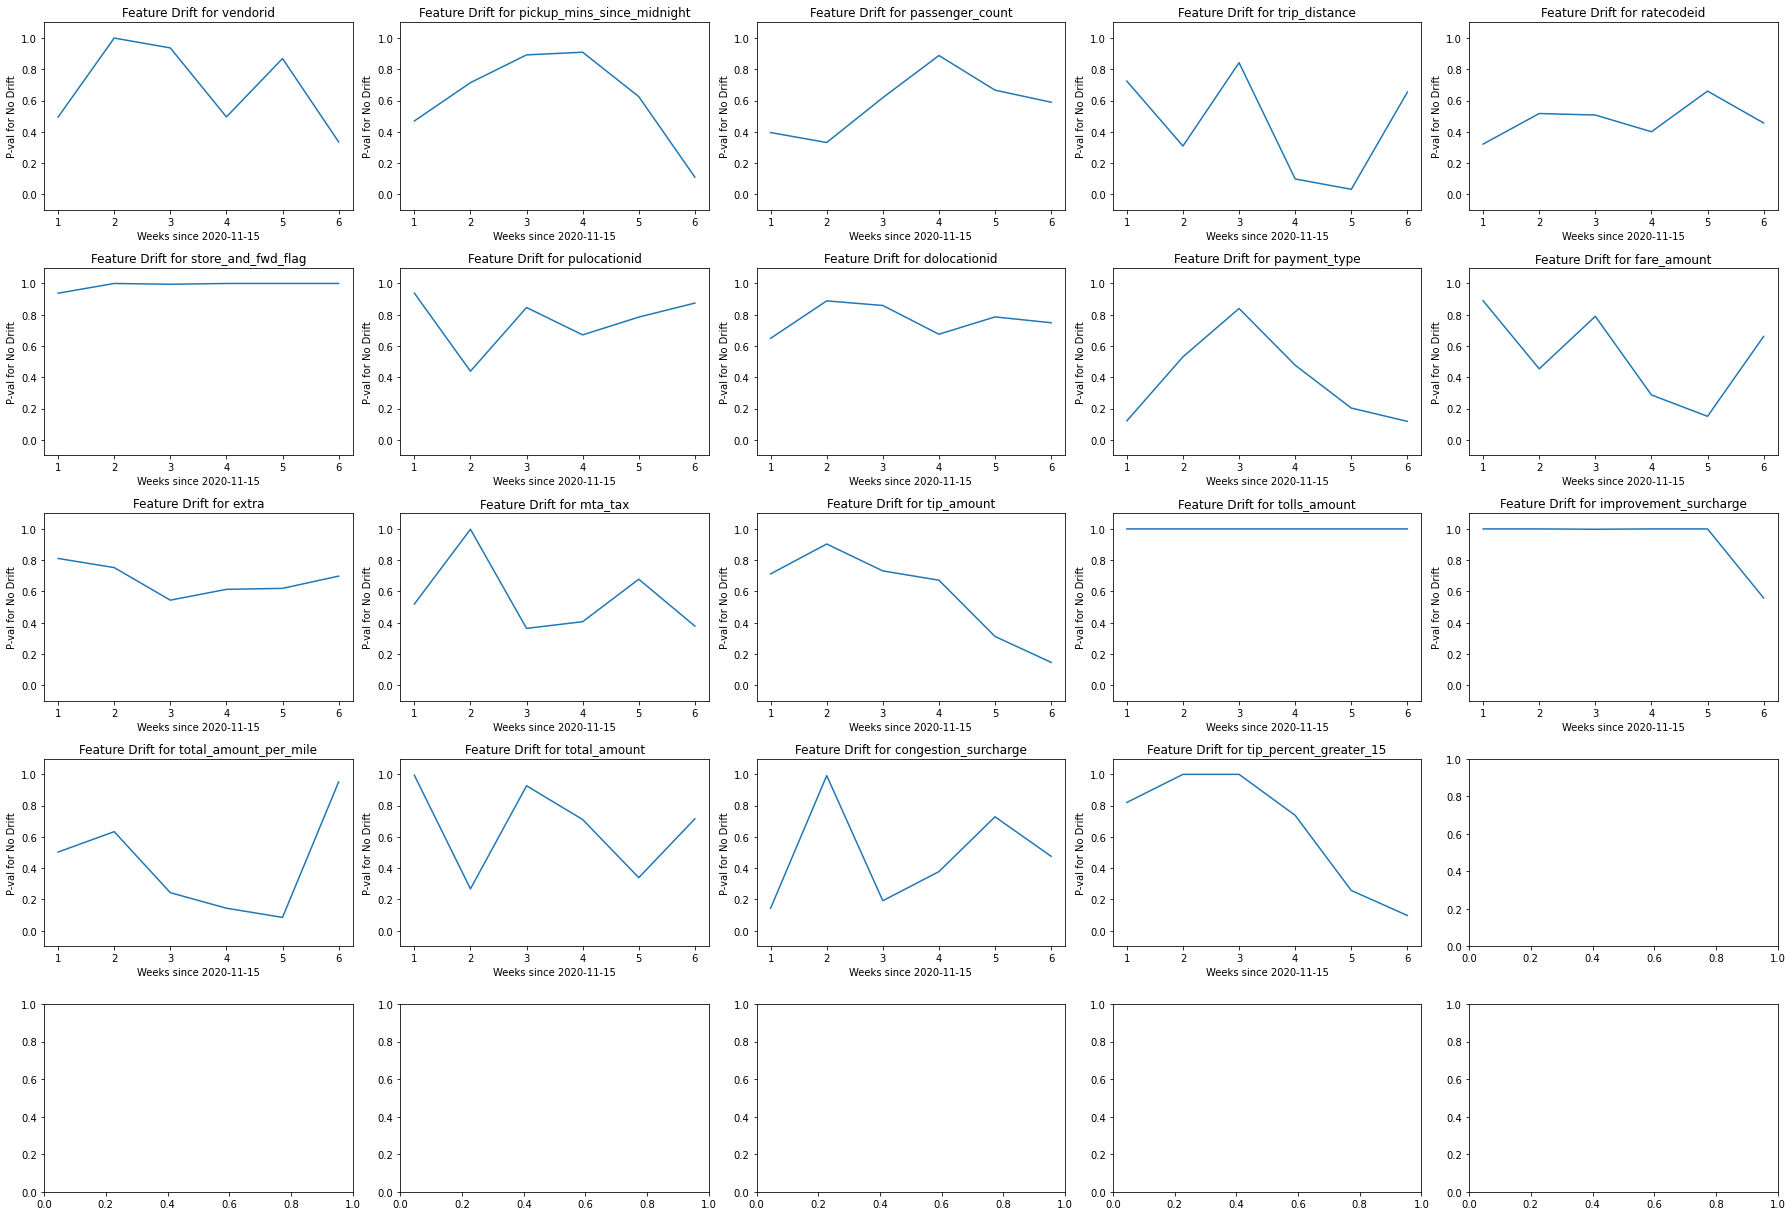

In [7]:
data_cols = [
       'vendorid',
       'pickup_mins_since_midnight',
       'passenger_count',
       'trip_distance',
       'ratecodeid',
       'store_and_fwd_flag',
       'pulocationid',
       'dolocationid',
       'payment_type',
       'fare_amount',
       'extra',
       'mta_tax',
       'tip_amount',
       'tolls_amount',
       'improvement_surcharge',
       'total_amount_per_mile',
       'total_amount',
       'congestion_surcharge',
       'tip_percent_greater_15']
df_data = df_sample[data_cols]
time_index_col = df_sample['tpep_pickup_datetime']
date_slices = tuple(
    date_iter_step_size(global_start_date, global_end_date))
accessor_factory_annotated = AccessorFactory(
    df_data, time_index_col, date_slices[0], date_slices[1:],
    is_continuous_annotations)

plot_interweek_performance(
    accessor_factory_annotated,
    TabularModel(),
    'tip_percent_greater_15')

In [8]:
x_labels = (
       'vendorid',
       'pickup_mins_since_midnight',
       'passenger_count',
       'trip_distance',
       'ratecodeid',
       'store_and_fwd_flag',
       'pulocationid',
       'dolocationid',
       'payment_type',
       'fare_amount',
       'extra',
       'mta_tax',
       'tip_amount',
       'tolls_amount',
       'improvement_surcharge',
       'total_amount_per_mile',
       'total_amount',
       'congestion_surcharge')
y_label = 'tip_percent_greater_15'
df_data = df_sample[list(x_labels + (y_label,))]
time_index_col = df_sample['tpep_pickup_datetime']
date_slices = tuple(
    date_iter_step_size(global_start_date, global_end_date))
accessor_factory_default = AccessorFactory(
    df_data, time_index_col, date_slices[0], date_slices[1:])
accessor_factory_annotated = AccessorFactory(
    df_data, time_index_col, date_slices[0], date_slices[1:],
    is_continuous_annotations)

drift_perf = get_drift_perf(
    accessor_factory_annotated, TabularModel(), x_labels, y_label)
np.savetxt('TabularModel.csv', drift_perf, delimiter=',')

drift_perf = get_drift_perf(
    accessor_factory_default, CVMModel(), x_labels, y_label)
np.savetxt('CVMModel.csv', drift_perf, delimiter=',')

drift_perf = get_drift_perf(
    accessor_factory_default, FETModel(), x_labels, y_label)
np.savetxt('FETModel.csv', drift_perf, delimiter=',')

drift_perf = get_drift_perf(
    accessor_factory_default, MMDModel(), x_labels, y_label)
np.savetxt('MMDModel.csv', drift_perf, delimiter=',')

proj = nn.Sequential(
    nn.Linear(len(x_labels),  10),
    nn.Linear(10, 10),
)
kernel = DeepKernel(proj, eps=0.01)
drift_perf = get_drift_perf(
    accessor_factory_default, LearnedKernelModel(kernel), x_labels, y_label)
np.savetxt('LearnedKernelModel.csv', drift_perf, delimiter=',')

model = nn.Sequential(
    nn.Linear(len(x_labels), 10),
    nn.ReLU(),
    nn.Linear(10, 2),
)
drift_perf = get_drift_perf(
    accessor_factory_default, ClassifierDriftModel(model), x_labels, y_label)
np.savetxt('ClassifierDriftModel.csv', drift_perf, delimiter=',')

drift_perf = get_drift_perf(
    accessor_factory_default, SpotTheDiffModel(), x_labels, y_label)
np.savetxt('SpotTheDiffModel.csv', drift_perf, delimiter=',')

model = nn.Sequential(
    nn.Linear(len(x_labels), 10),
    nn.ReLU(),
    nn.Linear(10, 2),
)
drift_perf = get_drift_perf(
    accessor_factory_default, ClassifierUncertaintyModel(model), x_labels, y_label)
np.savetxt('SpotTheDiffModel.csv', drift_perf, delimiter=',')

No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


In [9]:
# TODO: get the f1 score of some model and also export csv